2020-04-19 20:33:26,746 INFO IrgnmCG                                  :: Running Tikhonov solver.
2020-04-19 20:33:27,284 INFO TikhonovCG                               :: Stopping rule triggered.
2020-04-19 20:33:27,324 INFO CountIterations                          :: iteration = 1 / 11
2020-04-19 20:33:27,326 INFO IrgnmCG                                  :: Running Tikhonov solver.
2020-04-19 20:33:27,857 INFO TikhonovCG                               :: Stopping rule triggered.
2020-04-19 20:33:27,893 INFO CountIterations                          :: iteration = 2 / 11
2020-04-19 20:33:27,893 INFO IrgnmCG                                  :: Running Tikhonov solver.
2020-04-19 20:33:28,331 INFO TikhonovCG                               :: Stopping rule triggered.
2020-04-19 20:33:28,367 INFO CountIterations                          :: iteration = 3 / 11
2020-04-19 20:33:28,368 INFO IrgnmCG                                  :: Running Tikhonov solver.
2020-04-19 20:33:28,828 INFO TikhonovC

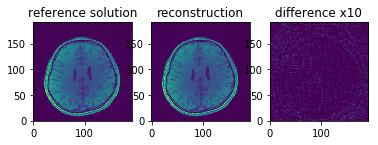

In [5]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import regpy as rp
import regpy.operators.mri as rpm
from regpy.solvers.irgnm import IrgnmCG

import cfl
from regpy_bart import BartNoir

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-40s :: %(message)s'
)


sobolev_index = 32
a = 220
noiselevel = None

datafile = 'data/unders_2_v8'
exact_data = np.ascontiguousarray(cfl.readcfl(datafile).T).squeeze()
pattern = rpm.estimate_sampling_pattern(exact_data)

ncoils, nx, ny = exact_data.shape
grid = rp.discrs.UniformGrid((-1, 1, nx), (-1, 1, ny), dtype=np.complex64)
bartop = BartNoir(grid, ncoils, pattern)
setting = rp.solvers.HilbertSpaceSetting(op=bartop, Hdomain=rp.hilbert.L2, Hcodomain=rp.hilbert.L2)

exact_data = exact_data[:, pattern].flatten()
exact_data = exact_data / setting.Hcodomain.norm(exact_data) * 100

if noiselevel is not None:
    data = (exact_data + noiselevel * bartop.codomain.randn(dtype=complex)).astype(np.complex64)
else:
    data = exact_data

init = bartop.domain.zeros()
init_density, init_coils = bartop.domain.split(init)
init_density[...] = 1
init_coils[...] = 0

reco, reco_data = IrgnmCG(
    setting, data, init=init,
    regpar=1, regpar_step=1/2, cgstop=5
).run(
    rp.stoprules.CountIterations(max_iterations=11)
    # +
    # rp.stoprules.Discrepancy(
    #     setting.Hcodomain.norm, data,
    #     noiselevel=setting.Hcodomain.norm(exact_data - data),
    #     tau=0.5
    # )
)

bart_reference = cfl.readcfl(datafile + '_bartref').T.squeeze()

fig, axes = plt.subplots(ncols=3)
axes[0].set_title('reference solution')
axes[1].set_title('reconstruction')
axes[2].set_title('difference x10')

# Plot exact solution
ref = axes[0].imshow(np.fliplr(np.abs(bart_reference).T), origin='lower')
ref.set_clim((0, ref.get_clim()[1]))

reco_postproc = rpm.normalize(*bartop.domain.split(bartop._forward_coils(reco)))
im = axes[1].imshow(np.fliplr(np.abs(reco_postproc).transpose()), origin='lower')
im.set_clim(ref.get_clim())
diff = axes[2].imshow(np.fliplr((np.abs(bart_reference) - np.abs(reco_postproc)).transpose()), origin='lower')
diff.set_clim((0, ref.get_clim()[1]/10.))

plt.show()